In [1]:
import numpy as np
import os
import glob
import re
from scipy import interpolate

In [2]:
def modecount_rebin(kk, pk, modes, minmodes=20, ndesired=200): #from MP-Gadget
    """Rebins a power spectrum so that there are sufficient modes in each bin"""
    assert np.all(kk) > 0
    logkk=np.log10(kk)
    mdlogk = (np.max(logkk) - np.min(logkk))/ndesired
    istart=iend=1
    count=0
    k_list=[kk[0]]
    pk_list=[pk[0]]
    targetlogk=mdlogk+logkk[istart]
    while iend < np.size(logkk)-1:
        count+=modes[iend]
        iend+=1
        if count >= minmodes and logkk[iend-1] >= targetlogk:
            pk1 = np.sum(modes[istart:iend]*pk[istart:iend])/count
            kk1 = np.sum(modes[istart:iend]*kk[istart:iend])/count
            k_list.append(kk1)
            pk_list.append(pk1)
            istart=iend
            targetlogk=mdlogk+logkk[istart]
            count=0
    k_list = np.array(k_list)
    pk_list = np.array(pk_list)
    return (k_list, pk_list)

def load_rebin(spec_file):
    k_raw, Pk_raw, modes = np.loadtxt(spec_file, usecols=(0,1,2), unpack=True)
    k, Pk = modecount_rebin(k_raw, Pk_raw, modes)
    return k, Pk

In [3]:
def load_interpolate(dir_base, k_cut, zs_obj, flatten=False):
    z_max = np.max(zs_obj)
    a_min = 1/(1+z_max)
    # get the list of files
    dir_sims = glob.glob(os.path.join(dir_base+'*'))

    # exclude the dirs that do not match the pattern: *_#### where #### is %04d
    dir_sims = [d for d in dir_sims if d[-5] == '_' and d[-4:].isdigit()]

    # sort the directories
    dir_sims.sort()

    lgP_sims_obj = []
    # loop over the directories and load the data
    for d in dir_sims:
        # data files of this simulation
        file_list = glob.glob(os.path.join(d,"output/powerspectrum-*.txt"))
        file_list.sort()

        print("Loading data from %s" % d)
        data_sim = []
        scale_factors = []

        for filepath in file_list:
            match = re.search(r"powerspectrum-([0-9]+\.[0-9]{4})\.txt", filepath)
            if match:
                scale_factor = float(match.group(1))
                if scale_factor < a_min:
                    continue
                k, Pk = load_rebin(filepath)
                data_sim.append(Pk)
                scale_factors.append(scale_factor)

        # Convert to NumPy arrays
        data_sim = np.array(data_sim)          # shape: (K, N, M)
        scale_factors = np.array(scale_factors)   # shape: (K,)
        zs = 1 / scale_factors - 1

        # cut off the high k part, keep only k<=k_cut, include k_cut within the data
        len_k = len(k[k<=k_cut]) + 1
        k = k[:len_k]
        data_sim = data_sim[:,:len(k)]

        # interpolate the data
        data_sim_obj = np.zeros((len(zs_obj), len(k)))
        for i in range(data_sim.shape[1]):
            f = interpolate.interp1d(zs, np.log10(data_sim[:,i]), kind='linear')
            data_sim_obj[:,i] = 10**f(zs_obj)

        # convert to log space
        lgk = np.log10(k)
        lgP_sim_obj = np.log10(data_sim_obj)

        # interpolate over lgk evenly spaced
        lgk_new = np.linspace(lgk.min(), lgk.max(), len(k))
        lgP_sim_obj_new = np.zeros((len(zs_obj), len(lgk_new)))
        for i in range(len(zs_obj)):
            f = interpolate.interp1d(lgk, lgP_sim_obj[i], kind='linear')
            lgP_sim_obj_new[i] = f(lgk_new)

        # flatten the data
        if flatten:
            lgP_sim_obj_new = lgP_sim_obj_new.flatten()
        lgP_sims_obj.append(lgP_sim_obj_new)

    return lgk_new, np.array(lgP_sims_obj)

In [4]:
# load data and interpolate (loop over all cosmologies)
# L1A
dir_l1_base = '/home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750'
zs_obj = zs_obj = np.linspace(0, 3, 40) # 40 redshifts
x_l = np.loadtxt('./narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_0.txt')
k_cut = 1
lgk_l1A, y_l1A = load_interpolate(dir_l1_base, k_cut, zs_obj) # lgk and lgP

# L2
dir_l2_base = '/home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box250_Part750'
# zs_obj = zs_obj = np.linspace(0, 3, 40) # 40 redshifts
# x_l2 = np.loadtxt('./narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_0.txt')
k_cut = 10
lgk_l2, y_l2 = load_interpolate(dir_l2_base, k_cut, zs_obj)

# PCA (just have a look at the data)

# save raw data

Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0000
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0001
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0002
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0003
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0004
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0005
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0006
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0007
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750_0008
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matt

Text(0.5, 1.0, 'L1A')

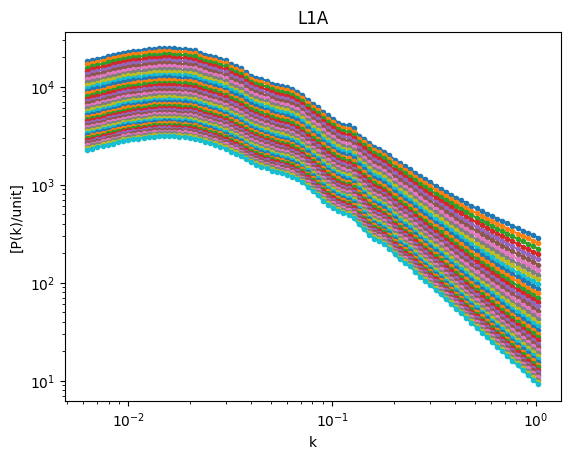

In [5]:
# plot L1A cosmo 0
import matplotlib.pyplot as plt
plt.figure()

# loop over all redshifts
for i in range(len(zs_obj)):
    # plt.plot(k_l1A, y_l1A[i_start:i_end], label='z=%.2f'%zs_obj[i])
    plt.plot(10**lgk_l1A, 10**y_l1A[0, i, :], '.-', label='z=%.2f'%zs_obj[i])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('[P(k)/unit]')
plt.title('L1A')

Text(0.5, 1.0, 'L2')

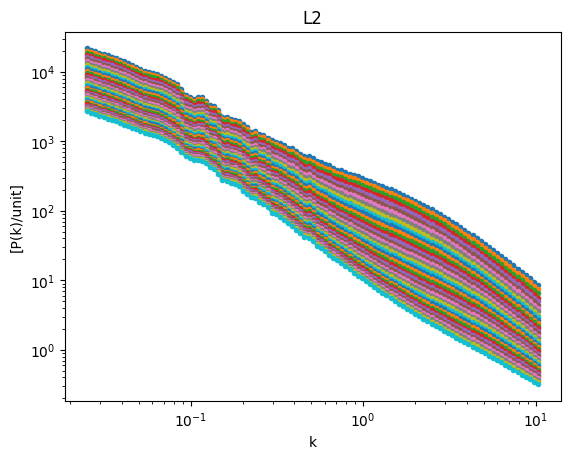

In [6]:
# plot L2 cosmo 0
plt.figure()

# loop over all redshifts
for i in range(len(zs_obj)):
    # plt.plot(k_l2, y_l2[i_start:i_end], label='z=%.2f'%zs_obj[i])
    plt.plot(10**lgk_l2, 10**y_l2[0, i, :], '.-', label='z=%.2f'%zs_obj[i])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('[P(k)/unit]')
plt.title('L2')

In [7]:
10**lgk_l2

array([ 0.0251327 ,  0.02654642,  0.02803966,  0.0296169 ,  0.03128286,
        0.03304252,  0.03490117,  0.03686437,  0.038938  ,  0.04112827,
        0.04344175,  0.04588535,  0.04846642,  0.05119266,  0.05407226,
        0.05711384,  0.0603265 ,  0.06371988,  0.06730414,  0.07109001,
        0.07508884,  0.07931261,  0.08377396,  0.08848626,  0.09346363,
        0.09872099,  0.10427406,  0.1101395 ,  0.11633487,  0.12287874,
        0.12979069,  0.13709145,  0.14480287,  0.15294807,  0.16155143,
        0.17063873,  0.1802372 ,  0.19037558,  0.20108425,  0.21239528,
        0.22434256,  0.23696188,  0.25029104,  0.26436997,  0.27924084,
        0.2949482 ,  0.3115391 ,  0.32906324,  0.34757312,  0.36712419,
        0.38777501,  0.40958744,  0.43262682,  0.45696218,  0.4826664 ,
        0.50981649,  0.53849378,  0.56878418,  0.60077842,  0.63457233,
        0.67026717,  0.70796985,  0.74779331,  0.78985685,  0.83428647,
        0.88121527,  0.93078383,  0.98314062,  1.0384425 ,  1.09

In [8]:
lgk_l2.shape

(111,)

In [9]:
# output data
dir_L1A = "N_L1A"
dir_L2 = "N_L2"

In [10]:
def save_data(dir, x, y, k):
    if not os.path.exists(dir):
        os.makedirs(dir)
    np.savetxt(os.path.join(dir, 'train_input.txt'), x)
    np.savetxt(os.path.join(dir, 'train_output.txt'), y)
    np.savetxt(os.path.join(dir, 'kf.txt'), k)

In [11]:
# save data
# flatten axis 1 and 2 as a new data array
y_l1A_reshaped = y_l1A.reshape(y_l1A.shape[0], -1)
y_l2_reshaped = y_l2.reshape(y_l2.shape[0], -1)

save_data(dir_L1A, x_l, y_l1A_reshaped, lgk_l1A)
save_data(dir_L2, x_l, y_l2_reshaped, lgk_l2)

In [12]:
lgk_l1A

array([-2.20181981, -2.17669042, -2.15156103, -2.12643164, -2.10130226,
       -2.07617287, -2.05104348, -2.02591409, -2.0007847 , -1.97565532,
       -1.95052593, -1.92539654, -1.90026715, -1.87513776, -1.85000837,
       -1.82487899, -1.7997496 , -1.77462021, -1.74949082, -1.72436143,
       -1.69923205, -1.67410266, -1.64897327, -1.62384388, -1.59871449,
       -1.57358511, -1.54845572, -1.52332633, -1.49819694, -1.47306755,
       -1.44793817, -1.42280878, -1.39767939, -1.37255   , -1.34742061,
       -1.32229123, -1.29716184, -1.27203245, -1.24690306, -1.22177367,
       -1.19664429, -1.1715149 , -1.14638551, -1.12125612, -1.09612673,
       -1.07099735, -1.04586796, -1.02073857, -0.99560918, -0.97047979,
       -0.94535041, -0.92022102, -0.89509163, -0.86996224, -0.84483285,
       -0.81970347, -0.79457408, -0.76944469, -0.7443153 , -0.71918591,
       -0.69405653, -0.66892714, -0.64379775, -0.61866836, -0.59353897,
       -0.56840959, -0.5432802 , -0.51815081, -0.49302142, -0.46

In [13]:
lgk_l1A.shape

(89,)

In [14]:
y_l1A.shape

(564, 40, 89)

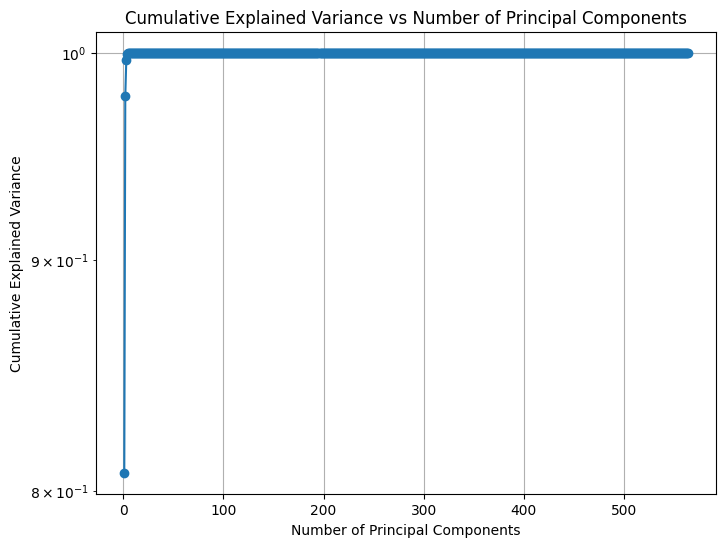

In [15]:
# PCA L1A
from sklearn.decomposition import PCA


# Fit PCA without limiting number of components
pca = PCA()
pca.fit(y_l1A_reshaped)

# Explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# y log scale
plt.yscale('log')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [16]:
cumulative_variance

array([0.80747226, 0.97806515, 0.99619069, 0.99931878, 0.99964924,
       0.99982434, 0.99991643, 0.99996492, 0.99998219, 0.99998896,
       0.99999291, 0.99999513, 0.99999656, 0.99999758, 0.99999828,
       0.99999872, 0.99999903, 0.9999993 , 0.99999942, 0.9999995 ,
       0.99999956, 0.9999996 , 0.99999963, 0.99999966, 0.99999968,
       0.99999971, 0.99999973, 0.99999975, 0.99999977, 0.99999979,
       0.9999998 , 0.99999982, 0.99999983, 0.99999984, 0.99999985,
       0.99999986, 0.99999987, 0.99999988, 0.99999989, 0.9999999 ,
       0.9999999 , 0.99999991, 0.99999992, 0.99999992, 0.99999993,
       0.99999993, 0.99999994, 0.99999994, 0.99999995, 0.99999995,
       0.99999996, 0.99999996, 0.99999996, 0.99999997, 0.99999997,
       0.99999997, 0.99999998, 0.99999998, 0.99999998, 0.99999998,
       0.99999998, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 1.        , 1.        , 1.     

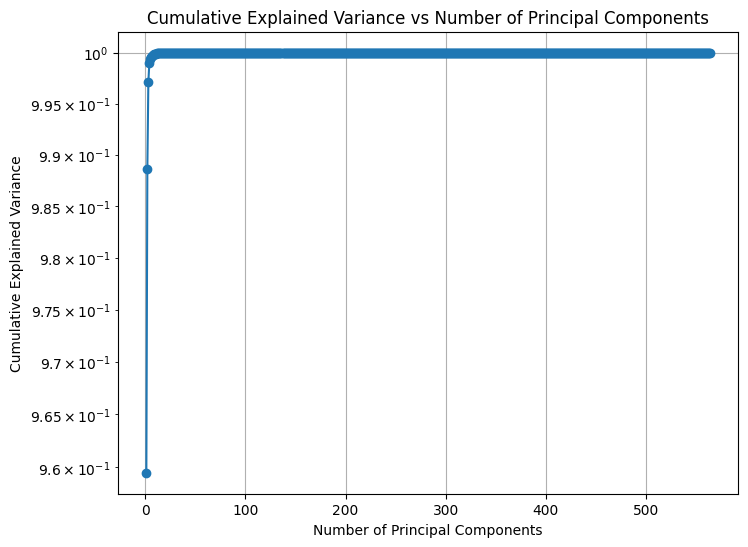

In [17]:
# PCA L2

# Fit PCA without limiting number of components
pca = PCA()
pca.fit(y_l2_reshaped)

# Explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# y log scale
plt.yscale('log')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [18]:
cumulative_variance

array([0.95947263, 0.98864725, 0.99711238, 0.99900569, 0.99934528,
       0.99958847, 0.99971503, 0.99980449, 0.99987898, 0.99990832,
       0.99992315, 0.99993656, 0.99994821, 0.99995763, 0.99996344,
       0.99996821, 0.99997241, 0.99997564, 0.99997824, 0.99998056,
       0.99998264, 0.99998453, 0.99998611, 0.99998731, 0.99998849,
       0.99998945, 0.9999903 , 0.99999101, 0.9999917 , 0.99999232,
       0.99999286, 0.99999338, 0.99999386, 0.99999432, 0.99999471,
       0.99999509, 0.99999543, 0.99999572, 0.99999601, 0.99999627,
       0.9999965 , 0.99999672, 0.99999692, 0.9999971 , 0.99999728,
       0.99999744, 0.99999758, 0.9999977 , 0.99999782, 0.99999791,
       0.99999801, 0.9999981 , 0.9999982 , 0.99999828, 0.99999836,
       0.99999843, 0.99999849, 0.99999856, 0.99999862, 0.99999868,
       0.99999874, 0.99999879, 0.99999884, 0.99999889, 0.99999893,
       0.99999897, 0.99999901, 0.99999905, 0.99999908, 0.99999911,
       0.99999915, 0.99999918, 0.99999921, 0.99999923, 0.99999

In [19]:
# load HF data
dir_h_base = '/home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000'
zs_obj = zs_obj = np.linspace(0, 3, 40) # 40 redshifts
x_h = np.loadtxt('./narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_1.txt')
k_cut = 15
lgk_h, y_h = load_interpolate(dir_h_base, k_cut, zs_obj, flatten=0) # lgk and lgP

Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0144
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0145
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0146
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0168
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0169
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0170
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0195
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0196
Loading data from /home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000_0197
Loading data from /home/yang/Desktop/Goku_matter_pow/na

In [20]:
# dirs to save data
dir_L1HAr = "N_L1HAr"
dir_L2Hr = "N_L2Hr"

In [21]:
lgk_h.shape

(143,)

In [22]:
lgk_h

array([-2.20181981, -2.17797499, -2.15413016, -2.13028534, -2.10644052,
       -2.0825957 , -2.05875087, -2.03490605, -2.01106123, -1.98721641,
       -1.96337159, -1.93952676, -1.91568194, -1.89183712, -1.8679923 ,
       -1.84414747, -1.82030265, -1.79645783, -1.77261301, -1.74876819,
       -1.72492336, -1.70107854, -1.67723372, -1.6533889 , -1.62954407,
       -1.60569925, -1.58185443, -1.55800961, -1.53416479, -1.51031996,
       -1.48647514, -1.46263032, -1.4387855 , -1.41494067, -1.39109585,
       -1.36725103, -1.34340621, -1.31956139, -1.29571656, -1.27187174,
       -1.24802692, -1.2241821 , -1.20033728, -1.17649245, -1.15264763,
       -1.12880281, -1.10495799, -1.08111316, -1.05726834, -1.03342352,
       -1.0095787 , -0.98573388, -0.96188905, -0.93804423, -0.91419941,
       -0.89035459, -0.86650976, -0.84266494, -0.81882012, -0.7949753 ,
       -0.77113048, -0.74728565, -0.72344083, -0.69959601, -0.67575119,
       -0.65190636, -0.62806154, -0.60421672, -0.5803719 , -0.55

In [23]:
lgk_l2

array([-1.59976085, -1.57599404, -1.55222723, -1.52846041, -1.5046936 ,
       -1.48092679, -1.45715997, -1.43339316, -1.40962635, -1.38585953,
       -1.36209272, -1.33832591, -1.31455909, -1.29079228, -1.26702547,
       -1.24325865, -1.21949184, -1.19572503, -1.17195821, -1.1481914 ,
       -1.12442459, -1.10065777, -1.07689096, -1.05312415, -1.02935733,
       -1.00559052, -0.98182371, -0.95805689, -0.93429008, -0.91052327,
       -0.88675645, -0.86298964, -0.83922283, -0.81545601, -0.7916892 ,
       -0.76792239, -0.74415557, -0.72038876, -0.69662195, -0.67285513,
       -0.64908832, -0.62532151, -0.60155469, -0.57778788, -0.55402107,
       -0.53025425, -0.50648744, -0.48272063, -0.45895381, -0.435187  ,
       -0.41142019, -0.38765337, -0.36388656, -0.34011975, -0.31635293,
       -0.29258612, -0.26881931, -0.24505249, -0.22128568, -0.19751887,
       -0.17375205, -0.14998524, -0.12621843, -0.10245161, -0.0786848 ,
       -0.05491799, -0.03115117, -0.00738436,  0.01638245,  0.04

In [24]:
y_h.shape

(15, 40, 143)

In [25]:
# loop over the L1 input and find the ones (indices) that are in the HF input
indices = []
for i in range(len(x_l)):
    if x_l[i] in x_h:
        indices.append(i)

print(indices)


[144, 145, 146, 168, 169, 170, 195, 196, 197, 204, 205, 206, 336, 337, 338]


In [26]:
# interpolate and ratio: y_HF / y_LF
# L1A
y_l1A_H = y_l1A[indices]
f = interpolate.interp1d(lgk_h, y_h, axis=2, kind='linear')
y_h_A = f(lgk_l1A)
r1A = y_h_A / y_l1A_H  # H cosmologies only

# L2
y_l2_H = y_l2[indices]
f = interpolate.interp1d(lgk_h, y_h, axis=2, kind='linear')
y_h_2 = f(lgk_l2)
r2 = y_h_2 / y_l2_H  # H cosmologies only

In [27]:
r1A.shape

(15, 40, 89)

In [28]:
# save data for ratio: L-H
# flatten axis 1 and 2 as a new data array
r1A_reshaped = r1A.reshape(r1A.shape[0], -1)
r2_reshaped = r2.reshape(r2.shape[0], -1)

save_data(dir_L1HAr, x_h, r1A_reshaped, lgk_l1A)
save_data(dir_L2Hr, x_h, r2_reshaped, lgk_l2)



In [29]:
r1A_reshaped.shape

(15, 3560)

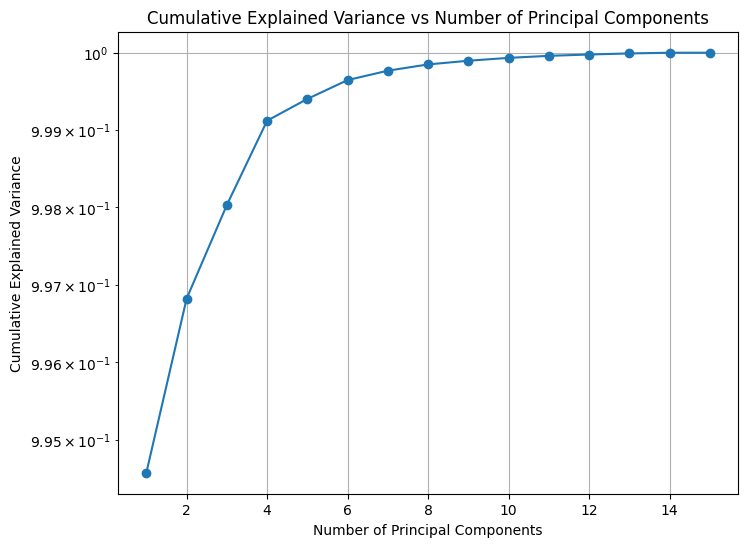

In [30]:
# PCA L1A-H ratio

# Fit PCA without limiting number of components
pca = PCA()
pca.fit(r1A_reshaped)

# Explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# y log scale
plt.yscale('log')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [31]:
cumulative_variance

array([0.99457588, 0.99682029, 0.99803065, 0.99912025, 0.99940209,
       0.99964605, 0.99976761, 0.99984849, 0.99989634, 0.99993332,
       0.99995985, 0.99997687, 0.9999908 , 1.        , 1.        ])

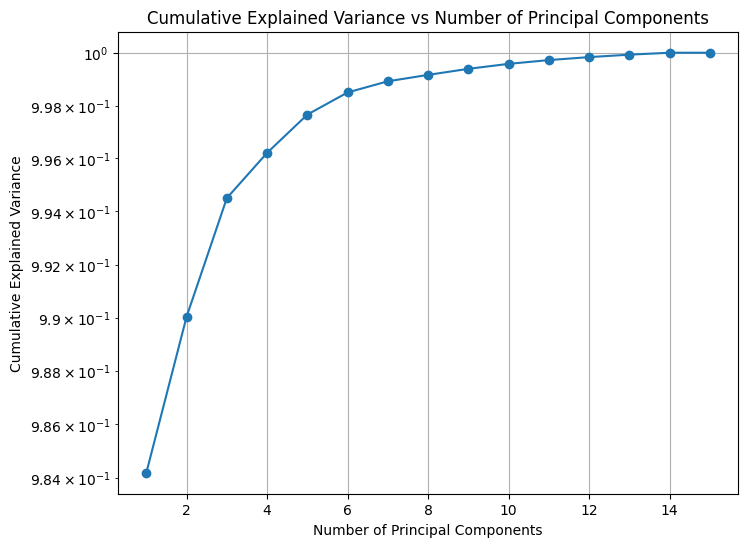

In [32]:
# PCA L2-H ratio

# Fit PCA without limiting number of components
pca = PCA()
pca.fit(r2_reshaped)

# Explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# y log scale
plt.yscale('log')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [33]:
cumulative_variance

array([0.98419844, 0.9900414 , 0.99450362, 0.99621128, 0.99765759,
       0.99849574, 0.99891758, 0.99916031, 0.99938951, 0.99957785,
       0.99972119, 0.99983364, 0.99992662, 1.        , 1.        ])